In [1]:
import kauri as kr
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
a = 1.25
b = 1
c = 0.75
A = 1
C = 1
omega = 0.25

one_over_a_sq = 1 / a**2
one_over_b_sq = 1 / b**2
one_over_c_sq = 1 / c**2

In [3]:
def H(p, q):
    t1 = (p[0]**2 + p[1]**2 + p[2]**2) / 2
    t2 = omega * (p[0] * q[1] - p[1] * q[0])
    t3 = A * math.log(C + (q[0]**2) * one_over_a_sq + (q[1]**2) * one_over_b_sq + (q[2]**2) * one_over_c_sq)
    return t1 + t2 + t3

def f(p, q):
    frac = 2 * A / (C + (q[0]**2) * one_over_a_sq + (q[1]**2) * one_over_b_sq + (q[2]**2) * one_over_c_sq)
    return [
        omega * p[1] - q[0] * one_over_a_sq * frac,
        -omega * p[0] - q[1] * one_over_b_sq * frac,
        -q[2] * one_over_c_sq * frac,
        p[0] + omega * q[1],
        p[1] - omega * q[0],
        p[2]
    ]

def f_(t, y):
    return f(y[:3], y[3:])

In [4]:
p0 = [0, 1.6888370059044757, 0.2]
q0 = [2.5, 0, 0]
y0 = p0 + q0

t0 = 0.
t_end = 1000000.
n = t_end * 40

In [5]:
# Check H = 2
H(p0, q0)

2.0

In [6]:
def poincare_section(y_vals_):
    q3_points = []
    q1_points = []
    q2 = -1
    for y in y_vals_:
        q3 = y[5]
        q2_ = y[4]
        q1 = y[3]
        #dq2 = y[1] - omega * y[3]
        if q1 > 0 and q2_ >= 0 and q2 < 0:
            q3_points.append(q3)
            q1_points.append(q1)
        q2 = y[4]
    return q3_points, q1_points

In [7]:
def plot_poincare(y_vals_):
    plt.rcParams["figure.figsize"] = (5,10)
    q3_points, q1_points = poincare_section(y_vals_)
    plt.scatter(q3_points, q1_points, s = 0.5, color = 'black', linewidth = 0, alpha = 1)
    plt.show()
    print(len(q3_points))

In [8]:
def galactic_orbit(method, plot = False):
    t_vals, y_vals = method.run(y0, t0, t_end, f_, n, tol = 1e-15, max_iter = 100000)
    y_vals = np.array(y_vals)
    
    with open(method.name + str(int(n/t_end)) + '.pickle', 'wb') as handle:
        pickle.dump((t_vals, y_vals), handle)

    if plot:
        plot_poincare(y_vals)

    q3_points, q1_points = poincare_section(y_vals)        
    print(method.name + ": ", "Points: ", len(q3_points), "Hamiltonian MAE: ", mae_H(t_vals, y_vals))

In [9]:
def mae_H(t_vals_, y_vals_):
    h_vals = []
    sum_h = 0
    for x in tqdm(y_vals_[::107]):
        h_ = H(x[:3], x[3:])
        sum_h += abs(h_ - 2)
        h_vals.append(h_)
    return sum_h / len(y_vals_)

In [10]:
def get_vals(t_vals_, y_vals_):
    q3_points, q1_points = poincare_section(y_vals_)
    print("Points: ", len(q3_points), "Hamiltonian MAE: ", mae_H(t_vals_, y_vals_))

# Classic Methods + EES27

In [11]:
n = int(t_end * 40)

In [12]:
methods = [kr.heun_rk2, kr.heun_rk3, kr.rk4, kr.ralston_rk4, kr.nystrom_rk5, kr.EES27((5 - 3 *math.sqrt(2))  / 14)]

for method in methods:
    galactic_orbit(method)

100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 129767.70it/s]


Heun RK2:  Points:  9455 Hamiltonian MAE:  0.001371130710375106


100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 133855.86it/s]


Heun RK3:  Points:  47766 Hamiltonian MAE:  0.0004900869139427228


100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 133909.15it/s]


RK4:  Points:  47004 Hamiltonian MAE:  1.0809772372972921e-07


100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 132346.08it/s]


Ralston RK4:  Points:  46991 Hamiltonian MAE:  1.1794417093509836e-07


100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 134006.19it/s]


Nystrom RK5:  Points:  47132 Hamiltonian MAE:  1.6612459896311148e-08


100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 127795.08it/s]


EES27:  Points:  47103 Hamiltonian MAE:  8.95968003522645e-12


# DOPRI856

In [13]:
from scipy.integrate import solve_ivp
import time

In [14]:
start = time.time()
i = 0
def f_wrapper(t,y):
    global i
    i += 1
    if i % 1000000 == 0:
        end = time.time()
        time_taken = end - start
        print("Elapsed: ", time_taken / 60)
    return f_(t,y)

In [15]:
def galactic_orbit_dopri856(plot = False):
    sol = solve_ivp(f_wrapper, (t0, t_end), y0, method='DOP853', t_eval=np.linspace(t0, t_end, n), rtol=1e-15, atol=1e-15)
    t_vals = sol.t
    y_vals = np.array(sol.y).T
    
    with open('dopri856.pickle', 'wb') as handle:
        pickle.dump((t_vals, y_vals), handle)

    if plot:
        plot_poincare(y_vals)
    print("DOPRI856:")
    get_vals(t_vals, y_vals)
    return sol

In [16]:
sol = galactic_orbit_dopri856()

C:\Users\Shmelev\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_ivp\rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


Elapsed:  0.7012041926383972
Elapsed:  1.4458547353744506
Elapsed:  2.2310139894485475
Elapsed:  3.0225817879041035
Elapsed:  3.810149383544922
Elapsed:  4.591820899645487
Elapsed:  5.37768063545227
Elapsed:  6.147588189442953
Elapsed:  6.91722100575765
Elapsed:  7.565726764996847
Elapsed:  8.35283103386561
Elapsed:  9.136662383874258
Elapsed:  9.930616370836894
Elapsed:  10.720433676242829
Elapsed:  11.505426506201426
Elapsed:  12.287521342436472
Elapsed:  13.056061104933422
Elapsed:  13.822712500890097
Elapsed:  14.591005071004231
Elapsed:  15.358948584397634
Elapsed:  16.1293390194575
Elapsed:  16.898820745944978
Elapsed:  17.663519191741944
Elapsed:  18.436765575408934
Elapsed:  19.202649255593617
Elapsed:  19.970732955137887
Elapsed:  20.74091533025106
Elapsed:  21.511162221431732
Elapsed:  22.30886886517207
Elapsed:  23.176775511105856
Elapsed:  23.954450710614523
Elapsed:  25.07438189983368
Elapsed:  25.84618190129598
Elapsed:  26.621064352989197
Elapsed:  27.399343462785087
Ela

100%|██████████████████████████████████████████████████████████████████████| 373832/373832 [00:02<00:00, 134367.98it/s]


Points:  47101 Hamiltonian MAE:  1.4699277731289317e-12


# Plots

In [17]:
h = '40'

with open('EES27' + h + '.pickle', 'rb') as handle:
    t40, ees27_14_data = pickle.load(handle)
    
with open('dopri856.pickle', 'rb') as handle:
    _, dopri_data = pickle.load(handle)

In [18]:
def plot_poincare_2(y_vals_, ax, title):
    q3_points, q1_points = poincare_section(y_vals_)
    ax.scatter(q3_points, q1_points, s = 0.5, color = 'black', linewidth = 0, alpha = 1, rasterized=True)
    ax.set_title(title, size = 14)
    print(len(q3_points))

47101
47103


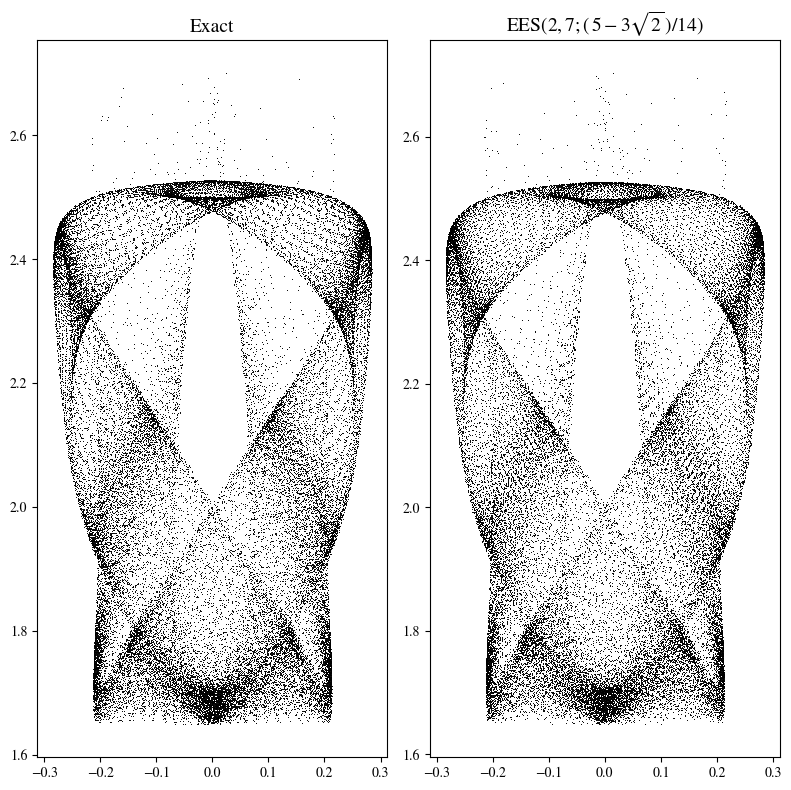

In [19]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams["figure.figsize"] = (8,8)
plt.rc('xtick', labelsize=10)  # fontsize of the tick labels
plt.rc('ytick', labelsize=10)  # fontsize of the tick labels

fig, ax = plt.subplots(nrows=1, ncols=2)

plot_poincare_2(dopri_data, ax[0], 'Exact')
plot_poincare_2(ees27_14_data, ax[1], r'$\text{EES}(2,7; ( \, 5 - 3 \sqrt{2}\, ) / 14)$')
plt.tight_layout()
plt.savefig('plots/poincare_plots.png', dpi=600)
plt.savefig('plots/poincare_plots.pdf', dpi=600)
plt.savefig('plots/poincare_plots.eps', dpi=600)
plt.show()